# imports

In [1]:
from mylib import base, dataset
from mylib.model_classification import ModelClass, load_or_create_and_fit_model, load_or_create_and_fit_GridSearchCV

from dotenv import dotenv_values
from pathlib import Path
from pprint import pprint, pformat
import joblib

import pandas as pd
import numpy as np

import plotly.express as plotly_px
import plotly.graph_objects as plotly_go
import plotly.subplots as plotly_subplt

#sys.path.insert(0, "..")

In [2]:
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_columns', 50) # Устанавливаем максимальное количество отображаемых столбцов равным 50
#pd.set_option('display.max_rows', 50) # Устанавливаем максимальное количество отображаемых строк равным 20
pd.options.display.float_format = '{:.5f}'.format # Устанавливаем формат отображения чисел с двумя знаками после запятой
pd.options.mode.use_inf_as_na = True # Настройка режима Pandas для рассмотрения бесконечностей (inf) как пропущенных значений (NA)

# Конфигурация формата отображения графиков в виде векторных изображений
%config InlineBackend.figure_format = 'svg'

# для построения графиков внутри Jupyter Notebook
%matplotlib inline

# 1. Загрузка конфигов

In [3]:
# загрузить параметры
settings_dict = {
    **dotenv_values("settings")
}

settings = base.Settings(settings_dict)
n_jobs = 8
verbose = 1

In [4]:
pprint(settings)

Settings(enviroment={'CACHE_SUBFOLDER': 'cached_results',
                     'DATASET_FILENAME_AFTER_EDA': '01_dataset_df_after_EDA.joblib',
                     'DATASET_FILENAME_READY_FOR_TRAIN_ORIGINAL': '02_dataset_catencoder_df_ready_for_train_original.joblib',
                     'DATASET_SUBFOLDER': 'dataset',
                     'GRID_SEARCH_TEMPLATE_FILENAME': '03_GridSearch_%s.pickle',
                     'MODEL_CLASS_TEMPLATE_FILENAME': '04_model_%s.pickle',
                     'PARAMS_FILENAME_AFTER_EDA': '01_params_after_EDA.joblib',
                     'PARAMS_FILENAME_READY_FOR_TRAIN_ORIGINAL': '02_params_ready_for_train_original.joblib',
                     'RESULT_SUBFOLDER': 'result'})


# Загрузитить датасет и подготовить его для обучения моделей

In [5]:
dataset_df = joblib.load(Path(settings.result_folder, settings.enviroment["DATASET_FILENAME_READY_FOR_TRAIN_ORIGINAL"]))
paams = joblib.load(Path(settings.result_folder, settings.enviroment["PARAMS_FILENAME_READY_FOR_TRAIN_ORIGINAL"]))
#dataset_df = dataset_df.sample(100, random_state=42)
X_train, X_test, y_train, y_test = dataset.prepare_dataset(dataset_df, paams)

# Модели классификации

## Decision Tree Classificator

In [6]:
# Decision Tree Classifier
from sklearn.tree import (
    DecisionTreeClassifier,  # Классификатор на основе дерева решений
    plot_tree,  # Функция для визуализации дерева решений
    export_text,  # Функция для экспорта дерева решений в текстовом формате
    export_graphviz  # Функция для экспорта дерева решений в формат Graphviz
)

# Импорт функций для визуализации дерева решений
from sklearn.tree import export_graphviz  # Функция для экспорта дерева решений в формат Graphviz
#import graphviz  # Библиотека для визуализации графов
from mlxtend.plotting import plot_decision_regions  # Функция для визуализации границ решений

dtc_model_name = 'DT_C'

### Подбор параметров для модели

In [7]:
dtc_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [1, 2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8, 16],
    'max_features': ['auto', 'sqrt', 'log2'],
    'random_state': [42],
    'ccp_alpha': [0, 0.01, 0.05, 0.1, 0.5, 1, 2]
}
    
dtc_grid_search = load_or_create_and_fit_GridSearchCV(dtc_model_name, DecisionTreeClassifier, dtc_param_grid, 
                                                      X_train, y_train, settings,
                                                      n_jobs=n_jobs, verbose=verbose)

Создается и выполняется GridSearchCV для модели DT_C класса DecisionTreeClassifier
Fitting 5 folds for each of 4200 candidates, totalling 21000 fits


In [8]:
print('Подобранные параметры:')
pprint(dtc_grid_search.best_params_)

Подобранные параметры:
{'ccp_alpha': 0,
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 16,
 'min_samples_split': 2,
 'random_state': 42}


### Обучение модели

In [9]:
dtc_model = load_or_create_and_fit_model(dtc_model_name, DecisionTreeClassifier, dtc_grid_search.best_params_, 
                                         X_train, X_test, y_train, y_test,
                                         settings)

dtc_model.show_quality()

Создается и тренируется модель DT_C класса DecisionTreeClassifier


### Специфическая визуализация для DecisionTreeClassifier

In [10]:
# Импорт функций для визуализации дерева решений
from sklearn.tree import export_graphviz  # Функция для экспорта дерева решений в формат Graphviz
import graphviz  # Библиотека для визуализации графов
# Импорт библиотеки для построения регионов решений
from mlxtend.plotting import plot_decision_regions  # Визуализация регионов решений
# Импорт метрик для оценки качества моделей
from sklearn.metrics import (
    classification_report,  # Отчет о классификации
    accuracy_score  # Метрика точности для классификации
)
import matplotlib.pyplot as plt  # Библиотека для создания графиков

from sklearn.tree import (
    plot_tree,  # Функция для визуализации дерева решений
    export_text  # Функция для экспорта дерева решений в текстовом формате
)

#### Визуализация дерева решений

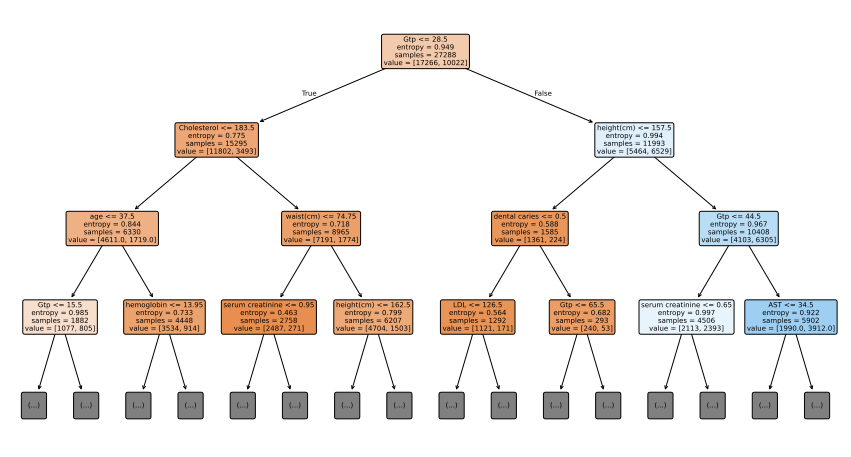

In [11]:
fig = plt.figure(figsize=(15, 8))
plot_tree(dtc_model.model, 
          feature_names=X_train.columns, 
          filled=True, 
          rounded=True, 
          max_depth=3,
          fontsize=7)          
plt.show()

In [12]:
text_representation = export_text(dtc_model.model, feature_names=X_train.columns)
print(text_representation)

|--- Gtp <= 28.50
|   |--- Cholesterol <= 183.50
|   |   |--- age <= 37.50
|   |   |   |--- Gtp <= 15.50
|   |   |   |   |--- ALT <= 18.50
|   |   |   |   |   |--- waist(cm) <= 71.55
|   |   |   |   |   |   |--- LDL <= 60.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- LDL >  60.50
|   |   |   |   |   |   |   |--- HDL <= 62.50
|   |   |   |   |   |   |   |   |--- hemoglobin <= 15.35
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- hemoglobin >  15.35
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- HDL >  62.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- waist(cm) >  71.55
|   |   |   |   |   |   |--- relaxation <= 80.50
|   |   |   |   |   |   |   |--- HDL <= 44.50
|   |   |   |   |   |   |   |   |--- HDL <= 40.50
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- HDL >  40.50
|   |   |   |   |   |   |   |   |   |--- class: 1


#### Выделение наиболее важного признака и построение модели только с ним

In [13]:
# Выделить наиболее важный признак
importances = dtc_model.model.feature_importances_
important_idx = np.argmax(importances)
important_feature = X_train.columns[important_idx]

print(f"Самый важный признак: {important_feature}")

Самый важный признак: Gtp


In [14]:
# Построить модель с одним признаком
dtc_single_model_name = "DT_C_Single"

X_train_single = X_train.iloc[:, important_idx].values.reshape(-1, 1) if hasattr(X_train, 'iloc') else X_train[:, important_idx].reshape(-1, 1)
X_test_single = X_test.iloc[:, important_idx].values.reshape(-1, 1) if hasattr(X_test, 'iloc') else X_test[:, important_idx].reshape(-1, 1)

dtc_single_model = load_or_create_and_fit_model(dtc_single_model_name, DecisionTreeClassifier, {}, 
                                         X_train_single, X_test_single, y_train, y_test,
                                         settings)

dtc_single_model.show_quality()

Создается и тренируется модель DT_C_Single класса DecisionTreeClassifier


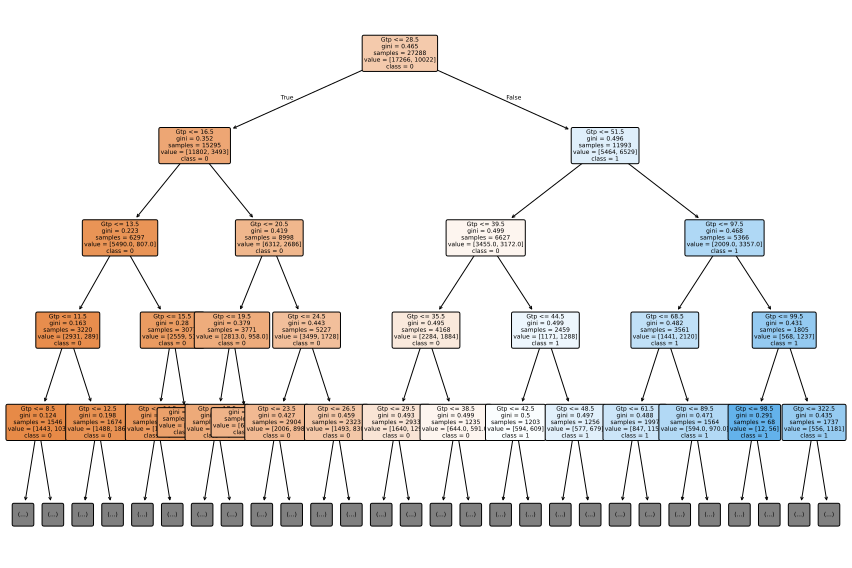

In [15]:
plt.figure(figsize=(15, 10))
plot_tree(dtc_single_model.model, 
          feature_names=[important_feature], 
          class_names=np.unique(y_train).astype(str),
          filled=True, 
          rounded=True,
          fontsize=6,
          max_depth=4)
plt.show()

## Support Vector Machine Classifier

In [16]:
from sklearn.svm import SVC

svc_model_name = 'SVM_C'

### Подбор параметров модели

In [17]:
svc_param_grid = {'C': [0.01, 0.1, 1, 5],
                'kernel':['linear', 'rbf'],
                'probability': [True]
                }
    
svc_grid_search = load_or_create_and_fit_GridSearchCV(svc_model_name, SVC, svc_param_grid, 
                                                      X_train, y_train, settings,
                                                      n_jobs=n_jobs, verbose=verbose)    

GridSearchCV() загружен из /home/igel/Projects/ml/ml-inno-hw/3. Machine Learning/3.07. Классификация Decision Tree/cached_results/03_GridSearch_SVM_C.pickle


In [18]:
print('Подобранные параметры:')
pprint(svc_grid_search.best_params_)

Подобранные параметры:
{'C': 5, 'kernel': 'rbf', 'probability': True}


### Обучение модели

In [19]:
svc_model = load_or_create_and_fit_model(svc_model_name, SVC, svc_grid_search.best_params_, 
                                         X_train, X_test, y_train, y_test,
                                         settings)

svc_model.show_quality()

Модель SVC загружена из /home/igel/Projects/ml/ml-inno-hw/3. Machine Learning/3.07. Классификация Decision Tree/cached_results/04_model_SVM_C.pickle


## KNN Classifier

In [20]:
from sklearn.neighbors import KNeighborsClassifier

knn_model_name = 'KNN_C'

### Подбор параметров модели

In [21]:
knn_param_grid = {'n_neighbors': range(1, 21), 
                  'p': [1, 2, 3]
                 }    
knn_grid_search = load_or_create_and_fit_GridSearchCV(knn_model_name, KNeighborsClassifier, knn_param_grid, 
                                                      X_train, y_train, settings,
                                                      n_jobs=n_jobs, verbose=verbose)        

GridSearchCV() загружен из /home/igel/Projects/ml/ml-inno-hw/3. Machine Learning/3.07. Классификация Decision Tree/cached_results/03_GridSearch_KNN_C.pickle


In [22]:
print('Подобранные параметры:')
pprint(knn_grid_search.best_params_)

Подобранные параметры:
{'n_neighbors': 20, 'p': 1}


### Обучение модели

In [23]:
knn_model = load_or_create_and_fit_model(knn_model_name, KNeighborsClassifier, knn_grid_search.best_params_, 
                                         X_train, X_test, y_train, y_test,
                                         settings)

knn_model.show_quality()

Модель KNeighborsClassifier загружена из /home/igel/Projects/ml/ml-inno-hw/3. Machine Learning/3.07. Классификация Decision Tree/cached_results/04_model_KNN_C.pickle


## Сравнительная таблица метрик разных моделей

In [24]:
df_stat = pd.concat([pd.DataFrame(dtc_model.metrics()),
                     pd.DataFrame(svc_model.metrics()),
                     pd.DataFrame(knn_model.metrics()),
                     pd.DataFrame(dtc_single_model.metrics())
                     ])
columns = ['model_name']
columns = columns + ModelClass.metrics_names()
df_stat2 = df_stat.pivot_table(columns = 'params',
                            index='model_name',
                            values='values').reset_index()[columns]
df_stat2

params,model_name,Training_Precision,Test_Precision,Training_Recall,Test_Recall,ROC_AUC_Train,ROC_AUC_Test,Accuarcy_Train,Accuarcy_Test,F1_score_Train,F1_score_Test
0,DT_C,0.56542,0.54026,0.93095,0.89502,0.84200,0.79791,0.71185,0.71185,0.70354,0.70354
1,DT_C_Single,0.50847,0.50733,0.75444,0.75698,0.73111,0.71702,0.64197,0.64197,0.60750,0.60750
2,KNN_C,0.54797,0.52951,0.90850,0.88128,0.82847,0.78239,0.69115,0.69115,0.68361,0.68361
3,SVM_C,0.57952,0.57388,0.86320,0.85801,0.82279,0.81427,0.71973,0.71973,0.69347,0.69347


In [25]:
dtc_model.show_quality()

In [26]:
dtc_single_model.show_quality()

In [27]:
svc_model.show_quality()

In [28]:
knn_model.show_quality()